In [1]:
import ctypes
import os
import sys
import pygmo as pg
from pygmo import *
import numpy as np
import sys  
import tsplib95
from numba import njit
import datetime
import matplotlib.pyplot as plt

# Travelling Salesman Problem
Well Known combinatorial optmization travelling salesman problem. We downloaded the tsp data dj38.tsp and qa194.tsp files from http://www.math.uwaterloo.ca/tsp/world/countries.html.

The objective was to optimize the path travelled by a salesman spanning 38 cities in case of djibouti and 194 in case of Qatar.

This is a combinatorial optimization problem and hence genetic algorithms are best suited for this problem. We used *Simple Genetic Algorithm* of PyGMO library. We created a population of random numbers between 0 and 1. Inside the objective function these numbers were then sorted using numpy argsort algorithm which gave the indices of numbers in asceding order. e.g. for X having 

1.56,1.78,3.4,1.9,1.2

Argsort returned 4,0,1,3,2. Each of these indices were the vertex of cities. The order of these vertex gave the order of travelling of the cities.

## Choice of parameters

### Generation
We used 5000 generations for solving the TSP of Djibouti. It gave us the most optimal solution for this problem. 
We used 25000 generation for Qatar TSP problem as it contained 194 cities thus requiring more processing.
### Mutation probability
In case of Djibouti the mutation probability is set to 0.06 so as to drive exploration. In case of Qatar we use lower value of mutation probability to ensure that good solution are not distorted too much.
### Selection Strategy
We use 'Tournament' as the selection strategy to introduce stochasticity or exploration in the algorithm
### Mutation Strategy
We use 'Uniform' as the mutation strategy so that all the individuals make movement towards the best individual. This is similar to Particle Swarm Oprimization social component.
### Crossover strategy
We use 'exponential'crossover strategy to ensure initial exploration and later exploitation
### Stopping criteria
We used 500,000 FES as the stopping criteria for Djibouti and 2.5 million FES for Qatar.
## Results
We ran the simple genetic algorithm of PyGMO on Djibouti and Qatar data. For Djibouti we got a perfect score of 6656 which was the most optimal path. For Qatar which has 194 cities we were able to get close to 11,000 as the distance which was slightly away from the least distance of 9352.

The output of the algorithms is shown below for both Djbouti and Qatar. The output also contains the fitness vs FES graph.

## C++ performance improvement
PyGMO python library sits on top of pagmo C++ library. To get significant performance gains in the time taken to run the optimization algorithm we use numba library njit. It is applied to the fitness function to minimize its execution time. We used numpy arrays to storing weights of the cities edges so that njit can run on it. The gains were massive and as large as 50 times in case of Qatar data.

## Parallel Architecture
We used simple single processing architecture initally. It was time consuming but gave out logs with details, which helped in fine tuning the parameters. Later on we switched to use an archipelago of islands to parallelize the algorithm execution and thereby speed up the computation especially for high dimensional problems like Qatar 194 cities problem. We obtained significant performance gains using the parallel archipelago based architecture. 

In [2]:
# Problem class of Travelling Salesman Problem for running PyGMO algortihms on it.
class TSP:
    def __init__(self, dim, filename):
        self.dim = dim
        self.upper = np.zeros([self.dim])
        self.lower = np.zeros([self.dim])
        # Get double numbers in the range of 0 to 1
        for i in range(self.dim):
            self.upper[i] = 1
            self.lower[i] = 0
        problem = tsplib95.load(filename)
        rows, cols = (self.dim,self.dim)
        self.weight_matrix = np.zeros((self.dim,self.dim,),dtype=float)
        # fill the weights in  weight_matrix which is a numpy 2D array to be used for 'No Python execution'
        for i in range(self.dim):
            for j in range(self.dim):
                edge = i+1,j+1 
                self.weight_matrix[i,j] = problem.get_weight(*edge)
    # njit for No python C++ execution for performance gains
    @njit
    def fitness_fast(dim,weight_mat,x):
        distance = 0.0
        # Arg sort the array of double numbers so that we get the indices of numbers in X sorted in ascending order
        indices_arr = np.argsort(x)
        for k in range(dim-1):
            weight = weight_mat[indices_arr[k],indices_arr[k+1]]
            distance = distance + weight
        # get the weight of the last edge connecting last vertex with starting vertex, which completes the Hamiltonian cycle
        weight = weight_mat[indices_arr[k+1],indices_arr[0]]
        distance = distance + weight
        return distance
    def fitness(self, x):
        retval = np.zeros((1,),dtype=float)
        retval[0]  = TSP.fitness_fast(self.dim,self.weight_matrix,x)
        return retval
    def get_bounds(self):
        return (self.lower,self.upper)
    def get_name(self):
        return "Travelling Salesman Problem"
    def get_extra_info(self):
        return "\tDimensions: " + str(self.dim)

In [3]:
# Function for running the algorithm WITHOUT the parallel architecture of Archipelago
def evaluate_TSP_Using_Default(dim, filename, num_gen, population_size, mutprob, optima ):
    prob = pg.problem(TSP(dim,filename))
    print(prob) 
    logs = []
    champion = []
    fitness_value = []
    generations = []
    Bestchamp = 0
    uda = sga(gen = num_gen, cr = 0.9, eta_c = 1.0, m = mutprob, param_m = 1.0, param_s = 2, crossover = 'exponential', mutation = 'uniform', selection = 'tournament')    
    start_time = datetime.datetime.now()
    for i in range(25):    
        algo = pg.algorithm(uda)
        algo.set_verbosity(100)
        pop = pg.population(prob, population_size)
        pop = algo.evolve(pop)
        if(pop.get_f()[pop.best_idx()][0] < Bestchamp):
            Bestchamp = pop.get_f()[pop.best_idx()][0]
            logs = algo.extract(type(uda)).get_log()
        champion.append( pop.get_f()[pop.best_idx()][0])
    
    for i in range(len(logs)):
        fitness_value.append(logs[i][2])
        generations.append(logs[i][1])
    
    plt.plot(generations, fitness_value) 
    # naming the x axis 
    plt.xlabel('Function Evals') 
    # naming the y axis 
    plt.ylabel('Fitness Value') 
    plt.show() 
    
    end_time = datetime.datetime.now()
    span = end_time-start_time
    champions = np.sort(champion)
    print("Best minimas of each run:")
    print(champions)
    print('Best loss:' + str(champions[0]-optima))
    print(" ".join(["Time span:",str(span.total_seconds())]))

In [4]:
# Function for running the algorithm with the parallel architecture of Archipelago
def evaluate_Problem_Using_Parallel_Architecture(dim, filename, num_gen, population_size, mutprob, optima):
    prob = pg.problem(TSP(dim,filename))
    print(prob)
    logs = []
    fitness_value = []
    generations = []
    # Setting bestchampion to large value
    Bestchamp = 1000000
    uda = sga(gen = num_gen, cr = 0.9, eta_c = 1.0, m = mutprob, param_m = 1.0, param_s = 2, crossover = 'exponential', mutation = 'uniform', selection = 'tournament')    
    algo = pg.algorithm(uda)
    algo.set_verbosity(100)
    archi = pg.archipelago(n=25,algo=algo, prob=prob, pop_size=population_size)
    start_time = datetime.datetime.now()
    archi.evolve() 
    archi.wait()
    print(algo.extract(type(uda)).get_log())        
    for i, island in enumerate(archi): # iterate through islands
        algois = island.get_algorithm()      # get algorithm from island
        popis = island.get_population()
        if(popis.get_f()[popis.best_idx()][0] < Bestchamp):
            Bestchamp = popis.get_f()[popis.best_idx()][0]
            logs = algois.extract(type(uda)).get_log()
        
    for i in range(len(logs)):
        fitness_value.append(logs[i][2])
        generations.append(logs[i][1])
    end_time = datetime.datetime.now()
    span = end_time-start_time
    plt.plot(generations, fitness_value) 
    # naming the x axis 
    plt.xlabel('Function Evals') 
    # naming the y axis 
    plt.ylabel('Fitness Value') 
    plt.show() 
    
    champions = np.sort(np.concatenate(archi.get_champions_f(), axis=0))
    print("Best minimas of each run:")
    print(champions)
    print('Best loss:' + str(champions[0]-optima))
    print(" ".join(["Time span:",str(span.total_seconds())]))

Problem name: Travelling Salesman Problem
	C++ class name: pybind11::object

	Global dimension:			38
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 38
[]


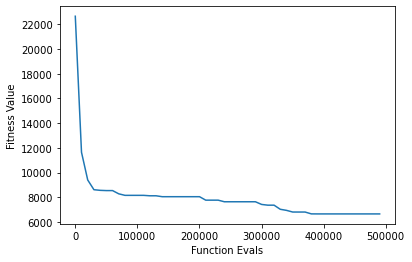

Best minimas of each run:
[6656. 6656. 6701. 6701. 6808. 6891. 7025. 7075. 7075. 7116. 7159. 7279.
 7360. 7446. 7526. 7540. 7549. 7634. 7654. 7677. 7710. 7810. 8032. 8038.
 8115.]
Best loss:0.0
Time span: 26.648189


In [5]:
# Run the algorithm for Djibouti data with 5000 generaions, 100 population size, and a mutation probality of 0.06
evaluate_Problem_Using_Parallel_Architecture(38,'./dj38.tsp', 5000, 100, 0.06, 6656)

Problem name: Travelling Salesman Problem
	C++ class name: pybind11::object

	Global dimension:			194
	Integer dimension:			0
	Fitness dimension:			1
	Number of objectives:			1
	Equality constraints dimension:		0
	Inequality constraints dimension:	0
	Lower bounds: [0, 0, 0, 0, 0, ... ]
	Upper bounds: [1, 1, 1, 1, 1, ... ]
	Has batch fitness evaluation: false

	Has gradient: false
	User implemented gradient sparsity: false
	Has hessians: false
	User implemented hessians sparsity: false

	Fitness evaluations: 0

	Thread safety: none

Extra info:
	Dimensions: 194
[]


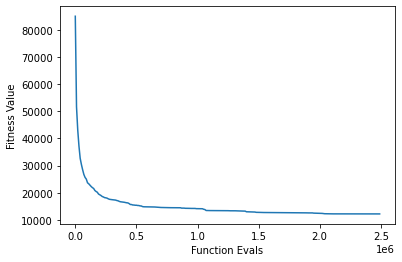

Best minimas of each run:
[12216. 13115. 13370. 13388. 13605. 13719. 13732. 13752. 13850. 14099.
 14104. 14180. 14275. 14513. 14698. 14868. 14943. 15024. 15133. 15285.
 15476. 15514. 15731. 16045. 16513.]
Best loss:2864.0
Time span: 355.431719


In [6]:
# Run the algorithm for Qatar data with 25000 generaions, 100 population size, and a mutation probality of 0.01
evaluate_Problem_Using_Parallel_Architecture(194,'./qa194.tsp', 25000, 100, 0.01, 9352)